# Experiment Report

#### Environment: 
CartPole

#### Algorithm: 
DQN and DQN with Experience Sharing on Unexplored Spaces

#### Goal: 
Test if applying experience sharing to DQN agents running in parallel in similar environments has a positive or negative impact to the agent's performance

#### Results Found:
Using 30 samples for each algorithm, no significant difference were found between the distributions.


# Procedures

Follows a comparison between two versions of DQN. In both, 2 agents learn how to play CartPole simultaneously, in different environments, but with the same dynamics (represented by similar transition and reward function).
The implementation is not parallel. Each agent plays 1000 steps, before switching over control to the next agent.

In the first implementation, there is no communication between agents, as they learn

In the second implementation, when passing over control from one agent to another, they share a batch of experiences. This batch of experiences is equal to 1000 steps, which will be added to the experience buffer of the next agent that takes control of the main thread.

It is import to remark that agent's have a limited experience buffer size, in this case set to 10000 steps. Hence these newly added experiences will solely be added to the front of the queue, causing the the oldest 1000 experiences to be removed from the queue

Some comments:
- Handling experience buffer as a deque might not be the best strategy. Can investigate into randomly removing experiences when the queue is full, instead of removing the oldest. This way we can keep some memories that last longer, and some memories that do not, which resemble more how the human mind works. We can also add a probability to be removed based on how old the experience is, so there is a chance it might stay, but if the experience stays too long in the buffer it will eventually be removed due to its decreasing probability of permanence.

## Results

In [8]:
exp_names = {
    'dqn-cartpole-v10': 'dqn-no-sharing',
    'dqn-cartpole-v11': 'dqn-sharing',
    'dqn-cartpole-v12': 'dqn-improved-sharing'
}

In [9]:
import pickle
results = {}
for file in ['dqn-cartpole-v10.pkl', 'dqn-cartpole-v11.pkl', 'dqn-cartpole-v12.pkl']:
    with open(file, 'rb') as f:
        res = pickle.load(f)
        dist = []
        dist.extend(res['agent1'])
        dist.extend(res['agent2'])
        for k, v in res.items():
            results[exp_names[file[:-4]]] = dist

For this trial, each model was executed for 30 trials and results gathered are shown above.

At first, we can begin by plotting the distributions to verify if there it seems to be a difference, before proceding to a more rigorous statistical analysis

In some episodes, an agent can get stuck in a local minima and the episode can take up to 10 or more times longer to get solved. These have shown to occur in several trials with different hyperparameters, and it is not particular to the experience sharing feature or any added feature.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [12]:
for name,dist in results.items():
    print(name)
    print("mean: ", np.mean(dist))
    print("std : ", np.std(dist))
    print("min : ", np.min(dist))
    print("max : ", np.max(dist))
    
    print("\n")

dqn-no-sharing
mean:  116.2964824120603
std :  36.790013087840286
min :  70
max :  312


dqn-sharing
mean:  113.555
std :  35.8929933970406
min :  68
max :  305


dqn-improved-sharing
mean:  116.7035175879397
std :  41.75505912462521
min :  76
max :  372




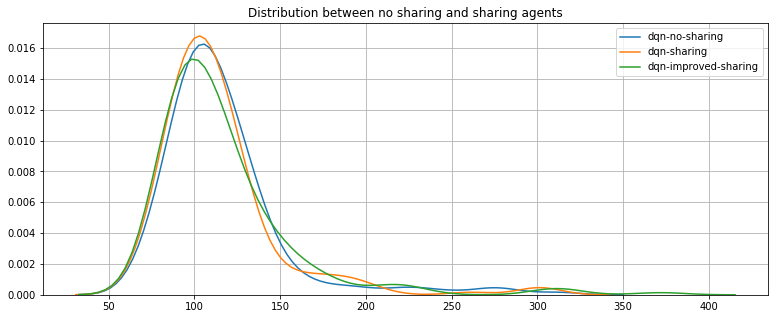

In [13]:
plt.figure(figsize=(13,5))
plt.title("Distribution between no sharing and sharing agents")
# plt.xticks(np.arange(0,300000,50000))
plt.grid()
for name, dist in results.items():
    sns.kdeplot(dist, label=name)

Looking at the histograms, it is not clear if there is a difference between the distributions. Let's see it a more rigorous statistical perspective if there indeed a difference between them. 

Since there is a high variance due to outliers (explained above why) we  use a Kolmogorov-Smirnov two sided test, considering the two distributions are independent, instead of a regular t-test which would rely on the mean of the distributions and would not give the full picture

In [14]:
from scipy import stats
from itertools import product, combinations

In [15]:
samples = list(combinations(results.items(),2))
# test the difference betweem all possible combinations
# agent1 no-sharing with agent1 sharing and agent 2 sharing
# agent2 no-sharing with agent1 sharing and agent 2 sharing
for sample in samples:
    print(sample[0][0], sample[1][0])
    print(stats.ks_2samp(sample[0][1], sample[1][1]))

dqn-no-sharing dqn-sharing
Ks_2sampResult(statistic=0.0683417085427136, pvalue=0.7253121241858821)
dqn-no-sharing dqn-improved-sharing
Ks_2sampResult(statistic=0.09547738693467334, pvalue=0.3095454425008093)
dqn-sharing dqn-improved-sharing
Ks_2sampResult(statistic=0.07100502512562812, pvalue=0.6803215176414082)


As per description of KS test in scipy library: 
> If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

Since all p-values are high, we cannot reject the hypothesis that the distributions of the two samples tested are the same. In other words, the difference in the distributions are not statistically significant, so we can not state the method introduced of experience sharing affected the algorithm's performance.